In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


In [3]:
DATASET_PATH = 'dataset/'

In [13]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 0.001

In [14]:
CLASS_NAMES = [
    'Bacterial Blight',
    'Brown Spot',
    'Leaf Smut',
    'Leaf Blast',
    'Leaf Scald',
    'Sheath Blight',
    'Healthy Rice Leaf'
]

print(f"Number of classes: {len(CLASS_NAMES)}")

Number of classes: 7


Bacterial Blight: 1604 images
Brown Spot: 1620 images
Leaf Smut: 1460 images
Leaf Blast: 634 images
Leaf Scald: 628 images
Sheath Blight: 632 images
Healthy Rice Leaf: 490 images


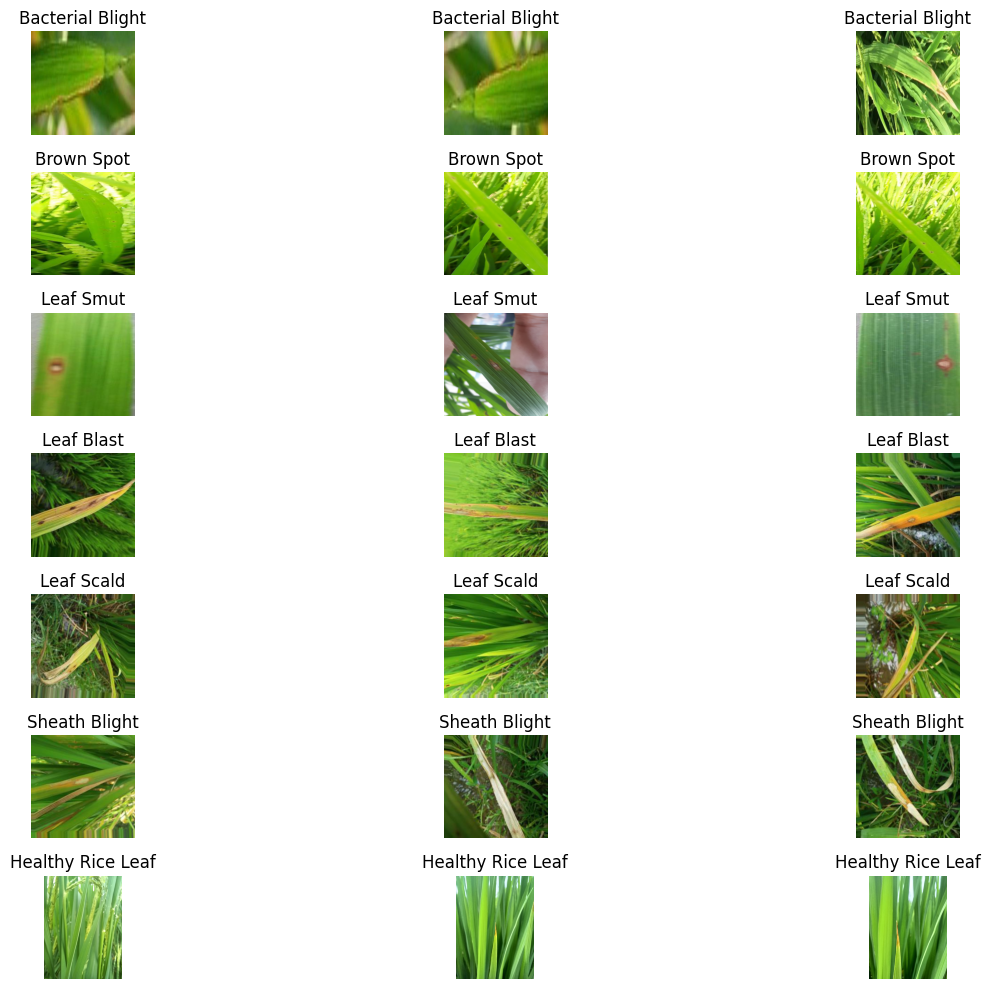

In [15]:
for class_name in CLASS_NAMES:
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.exists(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{class_name}: {num_images} images")
    else:
        print(f"WARNING: {class_name} directory not found!")

# Load and visualize sample images
def display_sample_images(dataset_path, class_names, samples_per_class=3):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)[:samples_per_class]
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(len(class_names), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(DATASET_PATH, CLASS_NAMES)

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% train, 20% validation
)

# Only rescaling for validation set
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create validation generator
validation_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 5657 images belonging to 7 classes.
Found 1411 images belonging to 7 classes.
Training samples: 5657
Validation samples: 1411
Class indices: {'Bacterial Blight': 0, 'Brown Spot': 1, 'Healthy Rice Leaf': 2, 'Leaf Blast': 3, 'Leaf Scald': 4, 'Leaf Smut': 5, 'Sheath Blight': 6}


In [17]:
def create_transfer_learning_model():
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(CLASS_NAMES), activation='softmax')
    ])
    
    return model

# Use transfer learning model (recommended for better performance)
model = create_transfer_learning_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,619,719 (9.99 MB)

 Trainable params: 361,735 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [20]:
checkpoint = ModelCheckpoint(
    'best_rice_disease_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, checkpoint]

In [21]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5022 - loss: 1.3736 - precision_1: 0.6280 - recall_1: 0.3635
Epoch 1: val_accuracy improved from None to 0.75053, saving model to best_rice_disease_model.keras
708/708 ━━━━━━━━━━━━━━━━━━━━ 116s 159ms/step - accuracy: 0.6017 - loss: 1.0496 - precision_1: 0.7254 - recall_1: 0.4810 - val_accuracy: 0.7505 - val_loss: 0.6638 - val_precision_1: 0.8752 - val_recall_1: 0.6364
Epoch 2/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7218 - loss: 0.7128 - precision_1: 0.8034 - recall_1: 0.6301
Epoch 2: val_accuracy improved from 0.75053 to 0.83345, saving model to best_rice_disease_model.keras
708/708 ━━━━━━━━━━━━━━━━━━━━ 114s 161ms/step - accuracy: 0.7458 - loss: 0.6684 - precision_1: 0.8202 - recall_1: 0.6677 - val_accuracy: 0.8335 - val_loss: 0.4726 - val_precision_1: 0.8923 - val_recall_1: 0.7690
Epoch 3/50
708/708 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7921 - loss: 0.5726 - precision_1: 0.8494 - recall_

KeyError: 'precision'

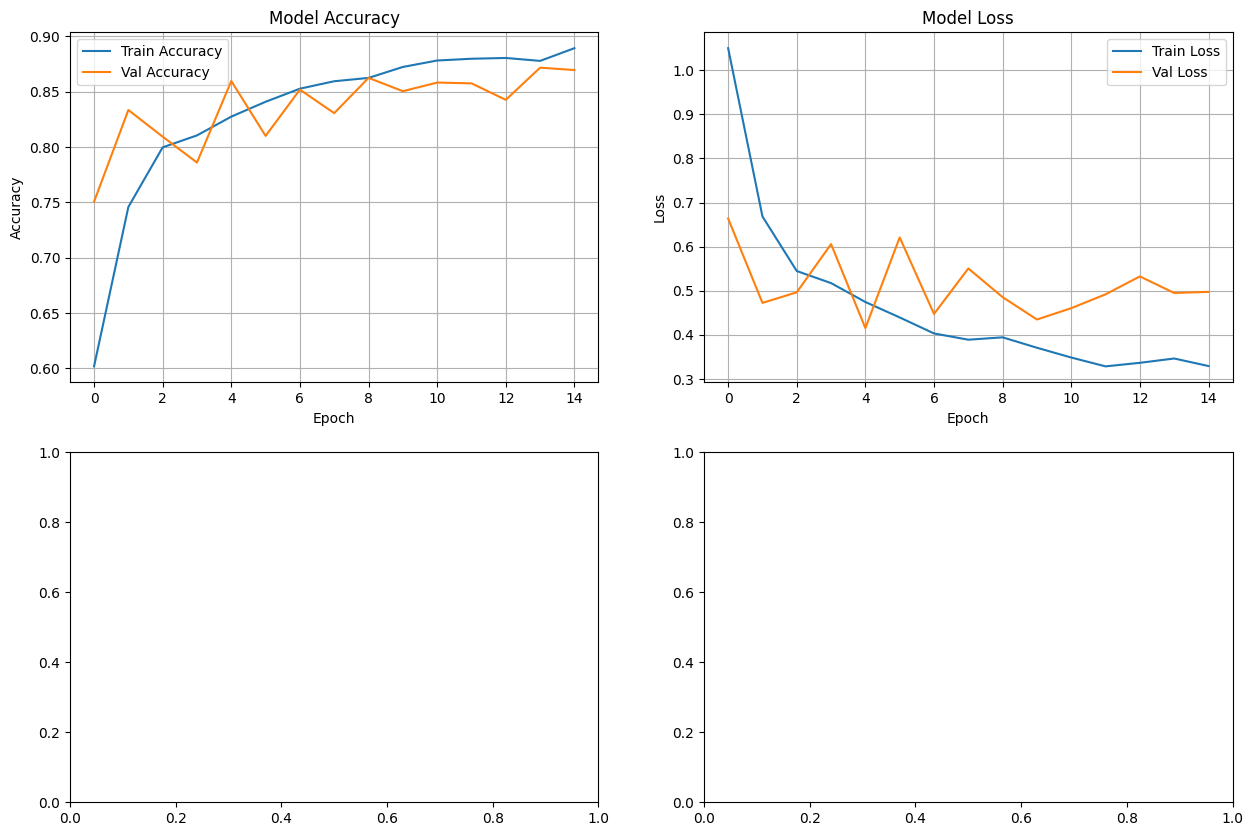

In [25]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.8597 - loss: 0.4154 - precision_1: 0.8832 - recall_1: 0.8363

Validation Results:
Loss: 0.4154
Accuracy: 0.8597
Precision: 0.8832
Recall: 0.8363
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step

Classification Report:
                   precision    recall  f1-score   support

 Bacterial Blight       0.86      0.99      0.92       320
       Brown Spot       0.97      1.00      0.98       324
        Leaf Smut       1.00      0.80      0.89        98
       Leaf Blast       0.87      0.37      0.52       126
       Leaf Scald       0.71      0.64      0.67       125
    Sheath Blight       0.99      0.91      0.95       292
Healthy Rice Leaf       0.52      0.83      0.64       126

         accuracy                           0.86      1411
        macro avg       0.85      0.79      0.80      1411
     weighted avg       0.88      0.86      0.86      1411



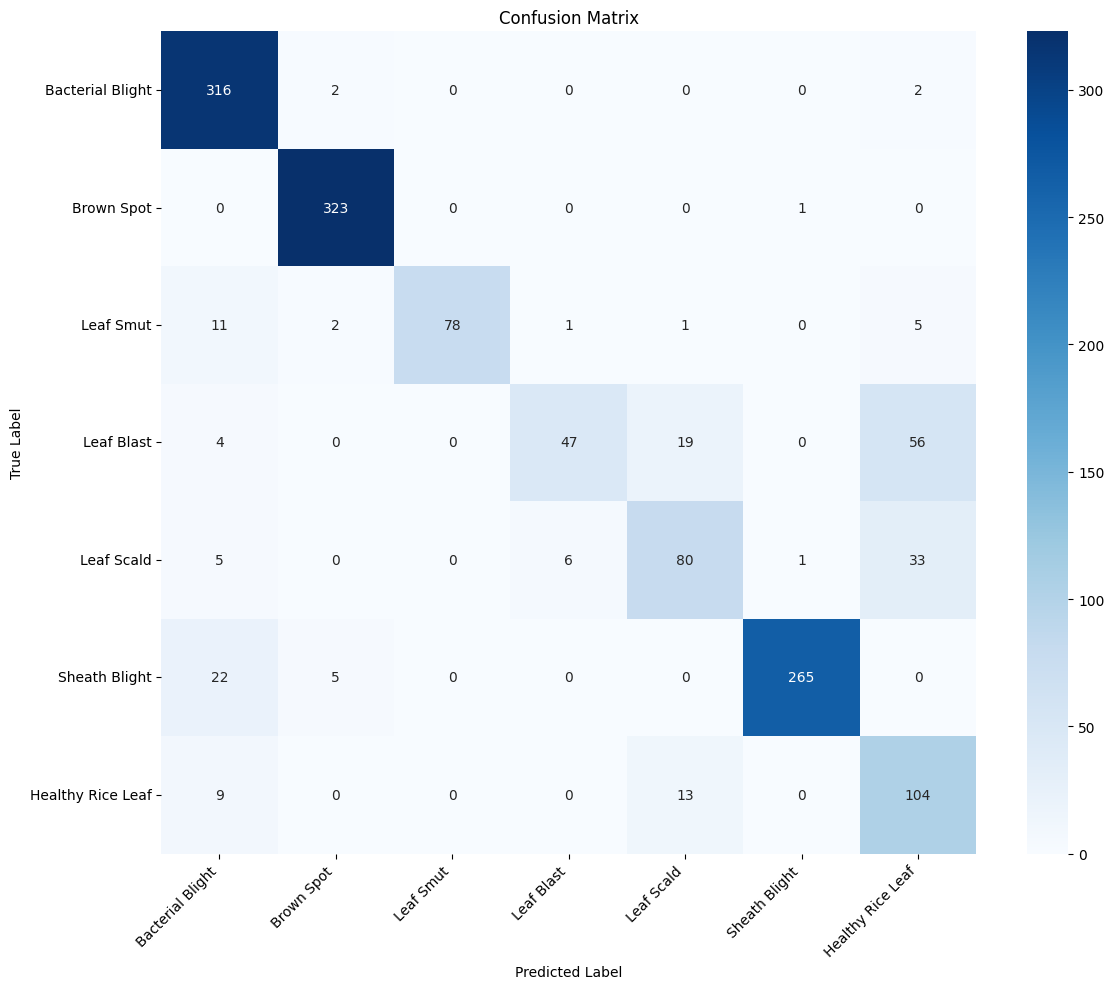

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on validation set
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(validation_generator)
print(f"\nValidation Results:")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")

# Generate predictions
validation_generator.reset()
predictions = model.predict(validation_generator, steps=len(validation_generator))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [27]:
model.save('rice_disease_classifier_final.keras')
print("Model saved successfully!")

# Save class names for later use
import json
with open('class_names.json', 'w') as f:
    json.dump(CLASS_NAMES, f)
print("Class names saved!")

Model saved successfully!
Class names saved!


In [28]:
def predict_disease(model, image_path, class_names):
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img_array = np.expand_dims(img_resized, axis=0) / 255.0
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx] * 100
    
    # Display result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[predicted_class_idx]}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.barh(class_names, predictions[0])
    plt.xlabel('Probability')
    plt.title('Class Probabilities')
    plt.tight_layout()
    plt.show()
    
    return class_names[predicted_class_idx], confidence

# Test with a sample image (update path)
# test_image_path = 'path/to/test/image.jpg'
# predict_disease(model, test_image_path, CLASS_NAMES)